# Modelado de Intercambio Aleatorio de Activos (RAE) 

En este trabajo se realizan simulaciones RAE. Se usaron los modelos en [Dragulescu & Yakovenko (2000)](https://doi.org/10.1007/s100510070114)

## Sistema económico cerrado con conservación de dinero

### Descripción del modelo

Los agentes económicos interaccionan a pares mediante transacciones monetarias. Solo se puede recibir o dar dinero en las transacciones.

Sean $i$ ("perdedor") y $j$ ("ganador") un par de agentes económicos que interaccionan. Sean $m$ y $m'$ la cantidad de dinero que posee un agente, antes y después de la transacción, la cual se da según

$$
m_i \longrightarrow m'_i = m_i - \Delta m \\
m_j \longrightarrow m'_j = m_j + \Delta m
$$

donde $\Delta m$ es el dinero que el "perdedor" transfirió al "ganador" después de la transacción.

Suposiciones y restricciones:

* El dinero se conserva, global y localmente, $m_i + m_j = m'_i + m'_j$
* El balance de los ganadores no puede ser negativo, $m_i \ge 0 \forall i$
* Una transacción se da solamente cuando el agente "perdedor" tiene el suficiente dinero para pagar, $m_i \ge \Delta m$
* No hay crédito ni deuda

La mecánica estadística predice que el sistema económico alcanzará la distribución estacionaria de Boltzmann-Gibbs,
$$
P\left( m \right) = \frac{1}{T} \exp \left(-m/T \right)
$$

donde
$$
T = \left\langle m \right\rangle = \frac{M}{N}
$$

es la "Temperatura de dinero", igual a la cantidad promedio de dinero $\left\langle m \right\rangle$. $M$ es la cantidad de dinero total en el sistema, y $N$ el número de agentes. 

### Cómo se realizan las simulaciones

Los pasos para realizar una simulación son los siguientes:
* Inicialmente todos los agentes tienen la misma cantidad de dinero.
* Se elige un par ($i,j$) de agentes al azar, y se realiza la transacción, es decir, se transfiere la cantidad $\Delta m$.
* Se repite el paso anterior muchas veces.

En este trabajo se realizan simulaciones con cada una de las siguientes reglas de intercambio:
* Regla 1: Intercambio de una pequeña cantidad constante, $\Delta m = 1$.
* Regla 2: Intercambio de una fracción aleatoria $0 \le \nu \le 1$ del dinero promedio del par, $\Delta m = \nu \left( m_i + m_j \right)/2$
* Regla 3: Intercambio de una fracción aleatoria $0 \le \nu \le 1$ del dinero promedio del sistema,  $\Delta m = \nu T$

Observese que estas reglas tienen simetría de inversión temporal, ya que son invariantes ante una permutación de los índices $i$ y $j$.

### Simulaciones

Los parámetros para las simulaciones son: $N = 5 \times 10^{5}$ y $M = 5 \times 10^{6}$. Por lo tanto, al principio de las simulaciones, los agentes contarán con la misma cantidad de dinero $\left\langle m \right\rangle = \frac{M}{N} = 10$.

In [73]:
# Parámetros
Nexp = 5
N = int(5*(10**Nexp)) # número de agentes

Mexp = 6
M = 5*(10**Mexp) # cantidad total de dinero en el sistema

T = M/N # temperatura de dinero

Reglas de intercambio:

In [74]:
# reglas de intercambio
exchange_rules = ['small_constant', 'random_pair_average', 'random_system_average']

In [76]:
from economic_agent import Agent
from random import randint
import matplotlib.pyplot as plt
import numpy as np

In [119]:
ex_order = 3 # Regla
exchange_rule = exchange_rules[ex_order - 1]

texp = 6
t_steps = int(4*(10**texp)) # Pasos de tiempo para la simulación

In [120]:
# Se crean a los agentes
agents_list = [Agent(money=T) for i in range(N)] # Todos los agentes tienen la misma cantidad de dinero
# Simulación
for i in range(t_steps):
    agent_i_index = randint(0,N-1)
    agent_j_index = randint(0,N-1) # se elige un par de agentes al azar para hacer transacción
    coin_flip = randint(0,1)
    loser_index = [agent_i_index,agent_j_index][coin_flip] # Uno de los agentes se selecciona al azar como el perdedor
    winner_index = [agent_i_index, agent_j_index][1-coin_flip]
    # El perdedor le paga al ganador
    agents_list[loser_index].pay(payee=agents_list[winner_index], transaction_type=exchange_rule, system_avg=T)

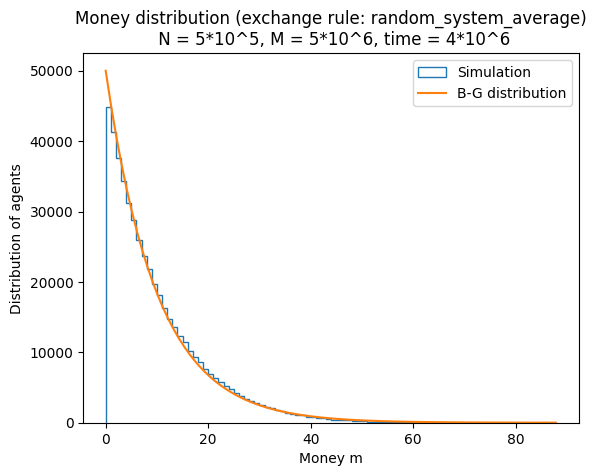

In [121]:
# Datos para el histograma
final_m_array = np.array([agent.money for agent in agents_list])
nb_bins = int(max(final_m_array))

# Distribución de Boltzmann-Gibbs
m_values = np.linspace(0,max(final_m_array),nb_bins)
P_values = N*(1/T)*np.exp(-m_values/T)

plt.hist(final_m_array, bins=range(nb_bins+2), label="Simulation", histtype='step')
plt.plot(m_values, P_values, label="B-G distribution")
plt.title(f"Money distribution (exchange rule: {exchange_rule})\n N = 5*10^{Nexp}, M = 5*10^{Mexp}, time = 4*10^{texp}")
plt.xlabel("Money m")
plt.ylabel("Distribution of agents")
#plt.yscale('log')
plt.legend()
plt.show()

En las simulaciones observamos que una distribución inicial estrecha, en la que todos los agentes tienen la misma cantidad de dinero, es inestable y evoluciona con el tiempo hacia una distribución amplia y sesgada, en la que muchos agentes tienen saldos monetarios bajos y pocos agentes tienen saldos monetarios altos. Finalmente, la distribución de dinero alcanza el equilibrio estadístico en la forma exponencial (la distribución de Boltzmann-Gibbs), de acuerdo con los principios generales de la física estadística y el principio de máxima entropía. 

Sin embargo, si una regla para transferencias de dinero no tiene simetría de inversión temporal (por ejemplo, $\Delta m \propto m_i$ es proporcional al saldo monetario de un agente), se pueden obtener otras distribuciones.

In [125]:
exchange_rule = 'proportional'

texp = 6
t_steps = int(4*(10**texp)) # Pasos de tiempo para la simulación

In [126]:
# Se crean a los agentes
agents_list = [Agent(money=T) for i in range(N)] # Todos los agentes tienen la misma cantidad de dinero
# Simulación
for i in range(t_steps):
    agent_i_index = randint(0,N-1)
    agent_j_index = randint(0,N-1) # se elige un par de agentes al azar para hacer transacción
    coin_flip = randint(0,1)
    loser_index = [agent_i_index,agent_j_index][coin_flip] # Uno de los agentes se selecciona al azar como el perdedor
    winner_index = [agent_i_index, agent_j_index][1-coin_flip]
    # El perdedor le paga al ganador
    agents_list[loser_index].pay(payee=agents_list[winner_index], transaction_type=exchange_rule, system_avg=T)

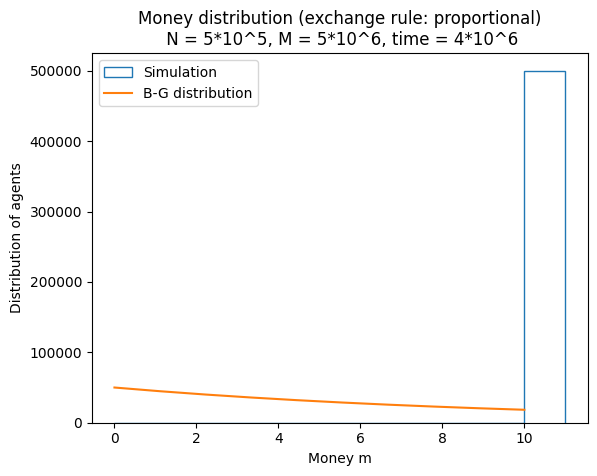

In [127]:
# Datos para el histograma
final_m_array = np.array([agent.money for agent in agents_list])
nb_bins = int(max(final_m_array))

# Distribución de Boltzmann-Gibbs
m_values = np.linspace(0,max(final_m_array),nb_bins)
P_values = N*(1/T)*np.exp(-m_values/T)

plt.hist(final_m_array, bins=range(nb_bins+2), label="Simulation", histtype='step')
plt.plot(m_values, P_values, label="B-G distribution")
plt.title(f"Money distribution (exchange rule: {exchange_rule})\n N = 5*10^{Nexp}, M = 5*10^{Mexp}, time = 4*10^{texp}")
plt.xlabel("Money m")
plt.ylabel("Distribution of agents")
#plt.yscale('log')
plt.legend()
plt.show()

## Modelos con deuda

Ahora analicemos qué sucede si se permite a los agentes endeudarse. La deuda puede considerarse como dinero negativo. Ahora bien, cuando un perdedor no tiene suficiente dinero para pagar, puede pedir prestada la cantidad necesaria a un depósito o "reservorio", y su saldo se vuelve negativo. No se viola la ley de conservación: la suma del dinero positivo del ganador y el dinero negativo del perdedor permanece constante. Cuando un agente con un saldo negativo recibe dinero como ganador, utiliza este dinero para pagar la deuda hasta que su saldo se vuelve positivo. 

Suponemos, para simplificar, que el "reservorio" no cobra intereses por el dinero prestado. Sin embargo, como no es sensato permitir una deuda ilimitada, ponemos un límite $m_d$ a la deuda máxima de un agente: $m_{i} > -m_{d}$. Esta nueva condición a la frontera $P\left( m < -m_{d} \right) = 0$ reemplaza a la vieja condición $P\left( m < 0 \right) = 0$. De nuevo $P\left( m \right)$ está dada por la ley de Boltzmann-Gibbs, 

$$
P\left( m  \right) = \frac{1}{T}\exp \left[ -\left( m+m_d \right)/T \right]
$$ 

(así se cumple la condición de normalización $\int_{-m_d}^{\infty }P\left( m  \right) dm = 1$), pero ahora,

$$
\left\langle m \right\rangle = \int_{-m_d}^{\infty }m P\left( m  \right) dm = T-m_{d}
$$

por lo que ahora se tiene una temperatura de dinero $T = M/N + m_{d}$ más alta.

### Descripción del modelo

Los agentes económicos interaccionan a pares mediante transacciones monetarias. Solo se puede recibir o dar dinero en las transacciones.

Sean $i$ ("perdedor") y $j$ ("ganador") un par de agentes económicos que interaccionan. Sean $m$ y $m'$ la cantidad de dinero que posee un agente, antes y después de la transacción, la cual se da según

$$
m_i \longrightarrow m'_i = m_i - \Delta m \\
m_j \longrightarrow m'_j = m_j + \Delta m
$$

donde $\Delta m$ es el dinero que el "perdedor" transfirió al "ganador" después de la transacción.

Suposiciones y restricciones:

* El dinero se conserva, global y localmente, $m_i + m_j = m'_i + m'_j$
* El balance de los ganadores no puede ser menor a la deuda máxima, $m_i \ge -m_{d} \forall i$
* Una transacción se da solamente cuando el agente "perdedor" tiene el suficiente dinero para pagar, $m_i \ge \Delta m - m_d$

### Cómo se realizan las simulaciones

Los pasos para realizar simulaciones son los mismos que en el modelo anterior.

### Simulaciones

## Un modelo más realista

Para que el modelo sea un poco más realista, introducimos empresas. Un agente a la vez se convierte en una empresa. La empresa toma prestado capital $K$ de otro agente y lo devuelve con un interés $rK$, contrata $L$ agentes y les paga un salario $W$, fabrica $Q$ artículos de un producto y los vende a $Q$ agentes a un precio $R$. Todos estos agentes son seleccionados aleatoriamente. La empresa recibe la ganancia
$$
F = RQ - LW - rK
$$

El resultado neto es un intercambio de dinero entre muchos cuerpos que aún satisface la ley de conservación.

Los parámetros del modelo que maximizan la ganancia se obtienen de la siguiente forma:

1) Se establece la curva de oferta-demanda agregada, $R\left( Q \right) = V/Q^{\eta}$, donde $Q$ es la cantidad de productos que la gente compraría a un precio $R$. $V = 100$ y $\eta = 1/2$ son constantes.
2) Se establece la función de producción de la firma, $Q\left( L,K \right) = L^{\beta}K^{1-\beta}$, con $\beta = 8/10$.
3) Se sustituyen las expresiones de los pasos anteriores en la ecuación de la ganacia, y se obtiene la ecuación $F\left( L,K \right) = V Q^{1-\eta} - LW - rK = V \left(L^{\beta}K^{1-\beta}\right)^{1-\eta} - LW - rK$
4) Se resuelve $\nabla F\left( L,K \right) = 0$ para maximizar la ganancia. La solución es 
$$
L_{critico} = \left( \frac{V \beta\left( 1-\eta \right)}{W} \right)^{1/\eta}\left( \frac{W \left( 1-\beta \right)}{r\beta} \right)^{\left(1-\beta\right)\left(1-\eta\right)/\eta}\\
K_{critico} = \frac{1-\beta}{\beta}\cdot\frac{W}{r}L_{critico}
$$

Una vez se establecen los valores de los parámetros $W$ y $r$, se pueden encontrar los valores de $L_{critico}$, $K_{critico}$, $Q_{c} = Q \left( L_{critico},K_{critico}  \right)$, $R_{c} = R \left( Q_c \right)$ y $F_{max}$, en ese orden. Por ejemplo, si $W = 10$ y $r=0.15$, entonces
$$
L_{critico} = \simeq 28\\
K_{critico} = 468.1\\
Q_{c} \simeq 49\\
R_{c} = 14.242\\
F_{max} = 351.075
$$

Es decir, con aquellos valores de salario y tasa de interés, la empresa obtendrá una ganancia máxima de 351.1$ si contrata a 28 trabajadores, toma prestado 468.1$ de capital, fabrica 49 artículos de su producto y los vende a 14.2$ cada uno.

### Cómo se van a realizar las simulaciones

Los pasos para realizar una simulación son los siguientes:
1) Se establecen los parámetros $N$, $T$ y $W$. Inicialmente todos los agentes tienen la misma cantidad de dinero $T$, y de ahí $M = N T$.
2) **Préstamo**: Se selecciona un par de agentes al azar del conjunto $A = \left\{ a_i \right\}_{i=1}^{N}$. El primer agente será la empresa $e$, y el segundo será el prestamista $p$. Antes del préstamo se establece una tasa de interés $r = \nu$, donde $\nu_{min} \le \nu \le \nu_{max}$ es una variable aleatoria uniforme. Se calculan los valores de $L_{critico}$, $K_{critico}$, $Q_c$ y $R_c$, en ese orden. El agente $p$ le presta un capital $\Delta m = K$ a $e$, con $K = K_{critico}$ (si $K_{critico}$ es mayor que la cantidad de dinero $m_{p}$ que posee el agente $p$, se repite este paso hasta que se encuentre un agente $p$ que pueda prestar capital).
3) **Contratación**: Se establece el número $L$ de trabajadores a contratar de la siguiente manera. Definamos a $f_{L} \equiv L/L_{critico}$ como la fracción de trabajadores que $e$ puede contratar. Si $m_e \ge L_{critico} W$, entonces $e$ tiene dinero suficiente para contratar un número de trabajadores que le permita maximizar su ganancia, por lo que $f_{L} = 1$ y $L = L_{critico}$; de lo contrario, $f_{L} = \frac{m_e}{L_{critico} W}$, y $L = f_{L} L_{critico} = m_{e}/W$.
4) **Producción**: Se seleccionan $L$ trabajadores al azar del conjunto $B = A - \left\{ e,p \right\}$. Estos trabajadores producen $Q = f_{L} Q_{c}$ artículos y se les paga el salario $\Delta m = W$ a cada uno de ellos por parte de $e$.
5) **Venta**: Se selecciona a $Q$ compradores al azar del conjunto $B$. A cada uno de estos compradores se le vende un artículo por parte de $e$ al precio $\Delta m = R_c$.
6) **Devolución**: El agente $e$ devuelve a $p$ la cantidad $\Delta m = \left( 1+r \right)K$ por los intereses.
7) Los pasos 2, 3, 4, 5 y 6 se llevan a cabo muchas veces.

### Simulaciones

Los parámetros para las simulaciones son: $N = 5 \times 10^{3}$, $T = 500$ y $W = 10$. Por lo tanto el dinero total en el sistema será $M = N T = 2.5 \times 10^{6}$. El rango para la tasa de interés será de $0.15 \le \nu \le 0.20$.

In [1]:
from economic_agent import CapitalistAgent_02
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Paso 1 (parametros)
Nexp = 3
N = int(5*(10**Nexp)) # número de agentes

T = 500 # Temperatura de dinero
W = 10 # Salario
M = N*T # cantidad total de dinero en el sistema
interest_range = (0.15,0.20)

In [7]:
texp = 4
t_steps = int(4*(10**texp)) # Pasos de tiempo para la simulación
# Se crean a los agentes
agents_list = np.array([CapitalistAgent_02(money=T) for i in range(N)]) # Todos los agentes tienen la misma cantidad de dinero
A_idx = range(N)
# Simulación
for i in range(t_steps):
    # Paso 2 (Préstamo)
    pair = np.random.choice(A_idx, size=2, replace=False)
    e_idx,p_idx = pair[0],pair[1]
    is_loan_taken = agents_list[e_idx].take_loan(from_agent=p_idx, W=W, interest_range=interest_range, agents_list=agents_list)

    if not is_loan_taken:
        continue

    # Paso 3 (Contratación)
    B_idx = np.array([a for a in A_idx if a not in [e_idx,p_idx]])
    f_L = agents_list[e_idx].hired_fraction(W=W)
    workers_idx = np.random.choice(B_idx, size=agents_list[e_idx].L, replace=False)
    #TODO Paso 4 (Producción)
    agents_list[e_idx].produce(with_workers=workers_idx, fraction=f_L, wage=W, agents_list=agents_list)
    #TODO Paso 5 (Venta)
    buyers_idx = np.random.choice(B_idx, size=agents_list[e_idx].Q, replace=False)
    agents_list[e_idx].sells(to_buyers=buyers_idx, agents_list=agents_list)
    #TODO Paso 6 (Devolución)
    agents_list[e_idx].return_loan(to_agent=p_idx, agents_list=agents_list)

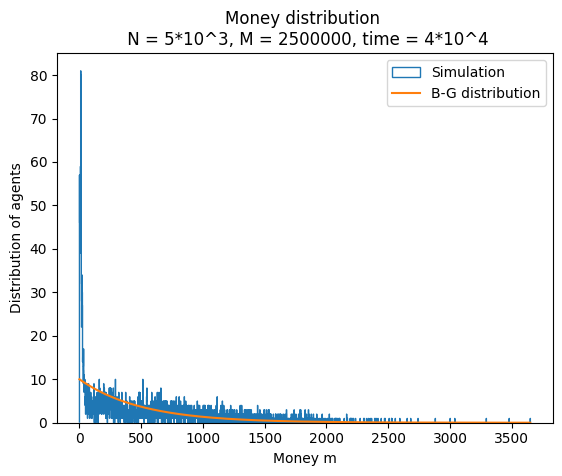

In [8]:
# Datos para el histograma
final_m_array = np.array([agent.money for agent in agents_list])
nb_bins = int(max(final_m_array))

# Distribución de Boltzmann-Gibbs
m_values = np.linspace(0,max(final_m_array),nb_bins)
P_values = N*(1/T)*np.exp(-m_values/T)

plt.hist(final_m_array, bins=range(nb_bins+2), label="Simulation", histtype='step', density=False)
plt.plot(m_values, P_values, label="B-G distribution")
plt.title(f"Money distribution \n N = 5*10^{Nexp}, M = {M}, time = 4*10^{texp}")
plt.xlabel("Money m")
plt.ylabel("Distribution of agents")
#plt.yscale('log')
plt.legend()
plt.show()

En la siguiente simulación obtenemos histogramas para los siguientes indicadores:
* Dinero
* Número de veces que un agente se vuelve empresario
* Número de veces que un agente se vuelve prestamista
* Número de veces que un agente se vuelve trabajador
* Número de veces que un agente se vuelve comprador

Parámetros: $N = 10^{4}$, $T = 500$, $W = 10$, $M = N T = 5 \times 10^{6}$, $0.15 \le \nu \le 0.20$.

In [1]:
from economic_agent import CapitalistAgent_03
import matplotlib.pyplot as plt
import numpy as np

In [16]:
#Paso 1 (parametros)
Nexp = 4
N = int(2*10**Nexp) # número de agentes

T = 500 # esta cantidad garantiza que todos los agentes puedan ser prestamistas al inicio
W = 10 # Salario
M = N*T # cantidad total de dinero en el sistema
interest_range = (0.15,0.20)

In [17]:
texp = 5
t_steps = int(10**texp) # Pasos de tiempo para la simulación

# Se crean a los agentes
agents_list = np.array([CapitalistAgent_03(money=T) for i in range(N)])
A_idx = range(N)
# Simulación
for i in range(t_steps):
    #Paso 2 (Préstamo)
    pair = np.random.choice(A_idx, size=2, replace=False)
    e_idx,p_idx = pair[0],pair[1]
    is_loan_taken = agents_list[e_idx].take_loan(from_agent=p_idx, W=W, interest_range=interest_range, agents_list=agents_list)

    if not is_loan_taken:
        continue

    #Paso 3 (Contratacion)
    B_idx = np.array([a for a in A_idx if a not in [e_idx,p_idx]])
    f_L = agents_list[e_idx].hired_fraction(W=W)
    workers_idx = np.random.choice(B_idx, size=agents_list[e_idx].L, replace=False)
    #Paso 4 (Producción)
    agents_list[e_idx].produce(with_workers=workers_idx, fraction=f_L, wage=W, agents_list=agents_list)
    #Paso 5 (Venta)
    buyers_idx = np.random.choice(B_idx, size=agents_list[e_idx].Q, replace=False)
    agents_list[e_idx].sells(to_buyers=buyers_idx, agents_list=agents_list)
    #Paso 6 (Devolución)
    agents_list[e_idx].return_loan(to_agent=p_idx, agents_list=agents_list)

In [18]:
# Datos para los histogramas
final_m_array = np.array([agent.money for agent in agents_list])
nb_m_bins = int(max(final_m_array))
final_e_array = np.array([agent.e for agent in agents_list])
nb_e_bins = int(max(final_e_array))
final_p_array = np.array([agent.p for agent in agents_list])
nb_p_bins = int(max(final_p_array))
final_w_array = np.array([agent.w for agent in agents_list])
nb_w_bins = int(max(final_w_array))
final_pu_array = np.array([agent.pu for agent in agents_list])
nb_pu_bins = int(max(final_pu_array))

# Distribución de Boltzmann-Gibbs
m_values = np.linspace(0,max(final_m_array),nb_m_bins)
P_values = N*(1/T)*np.exp(-m_values/T)

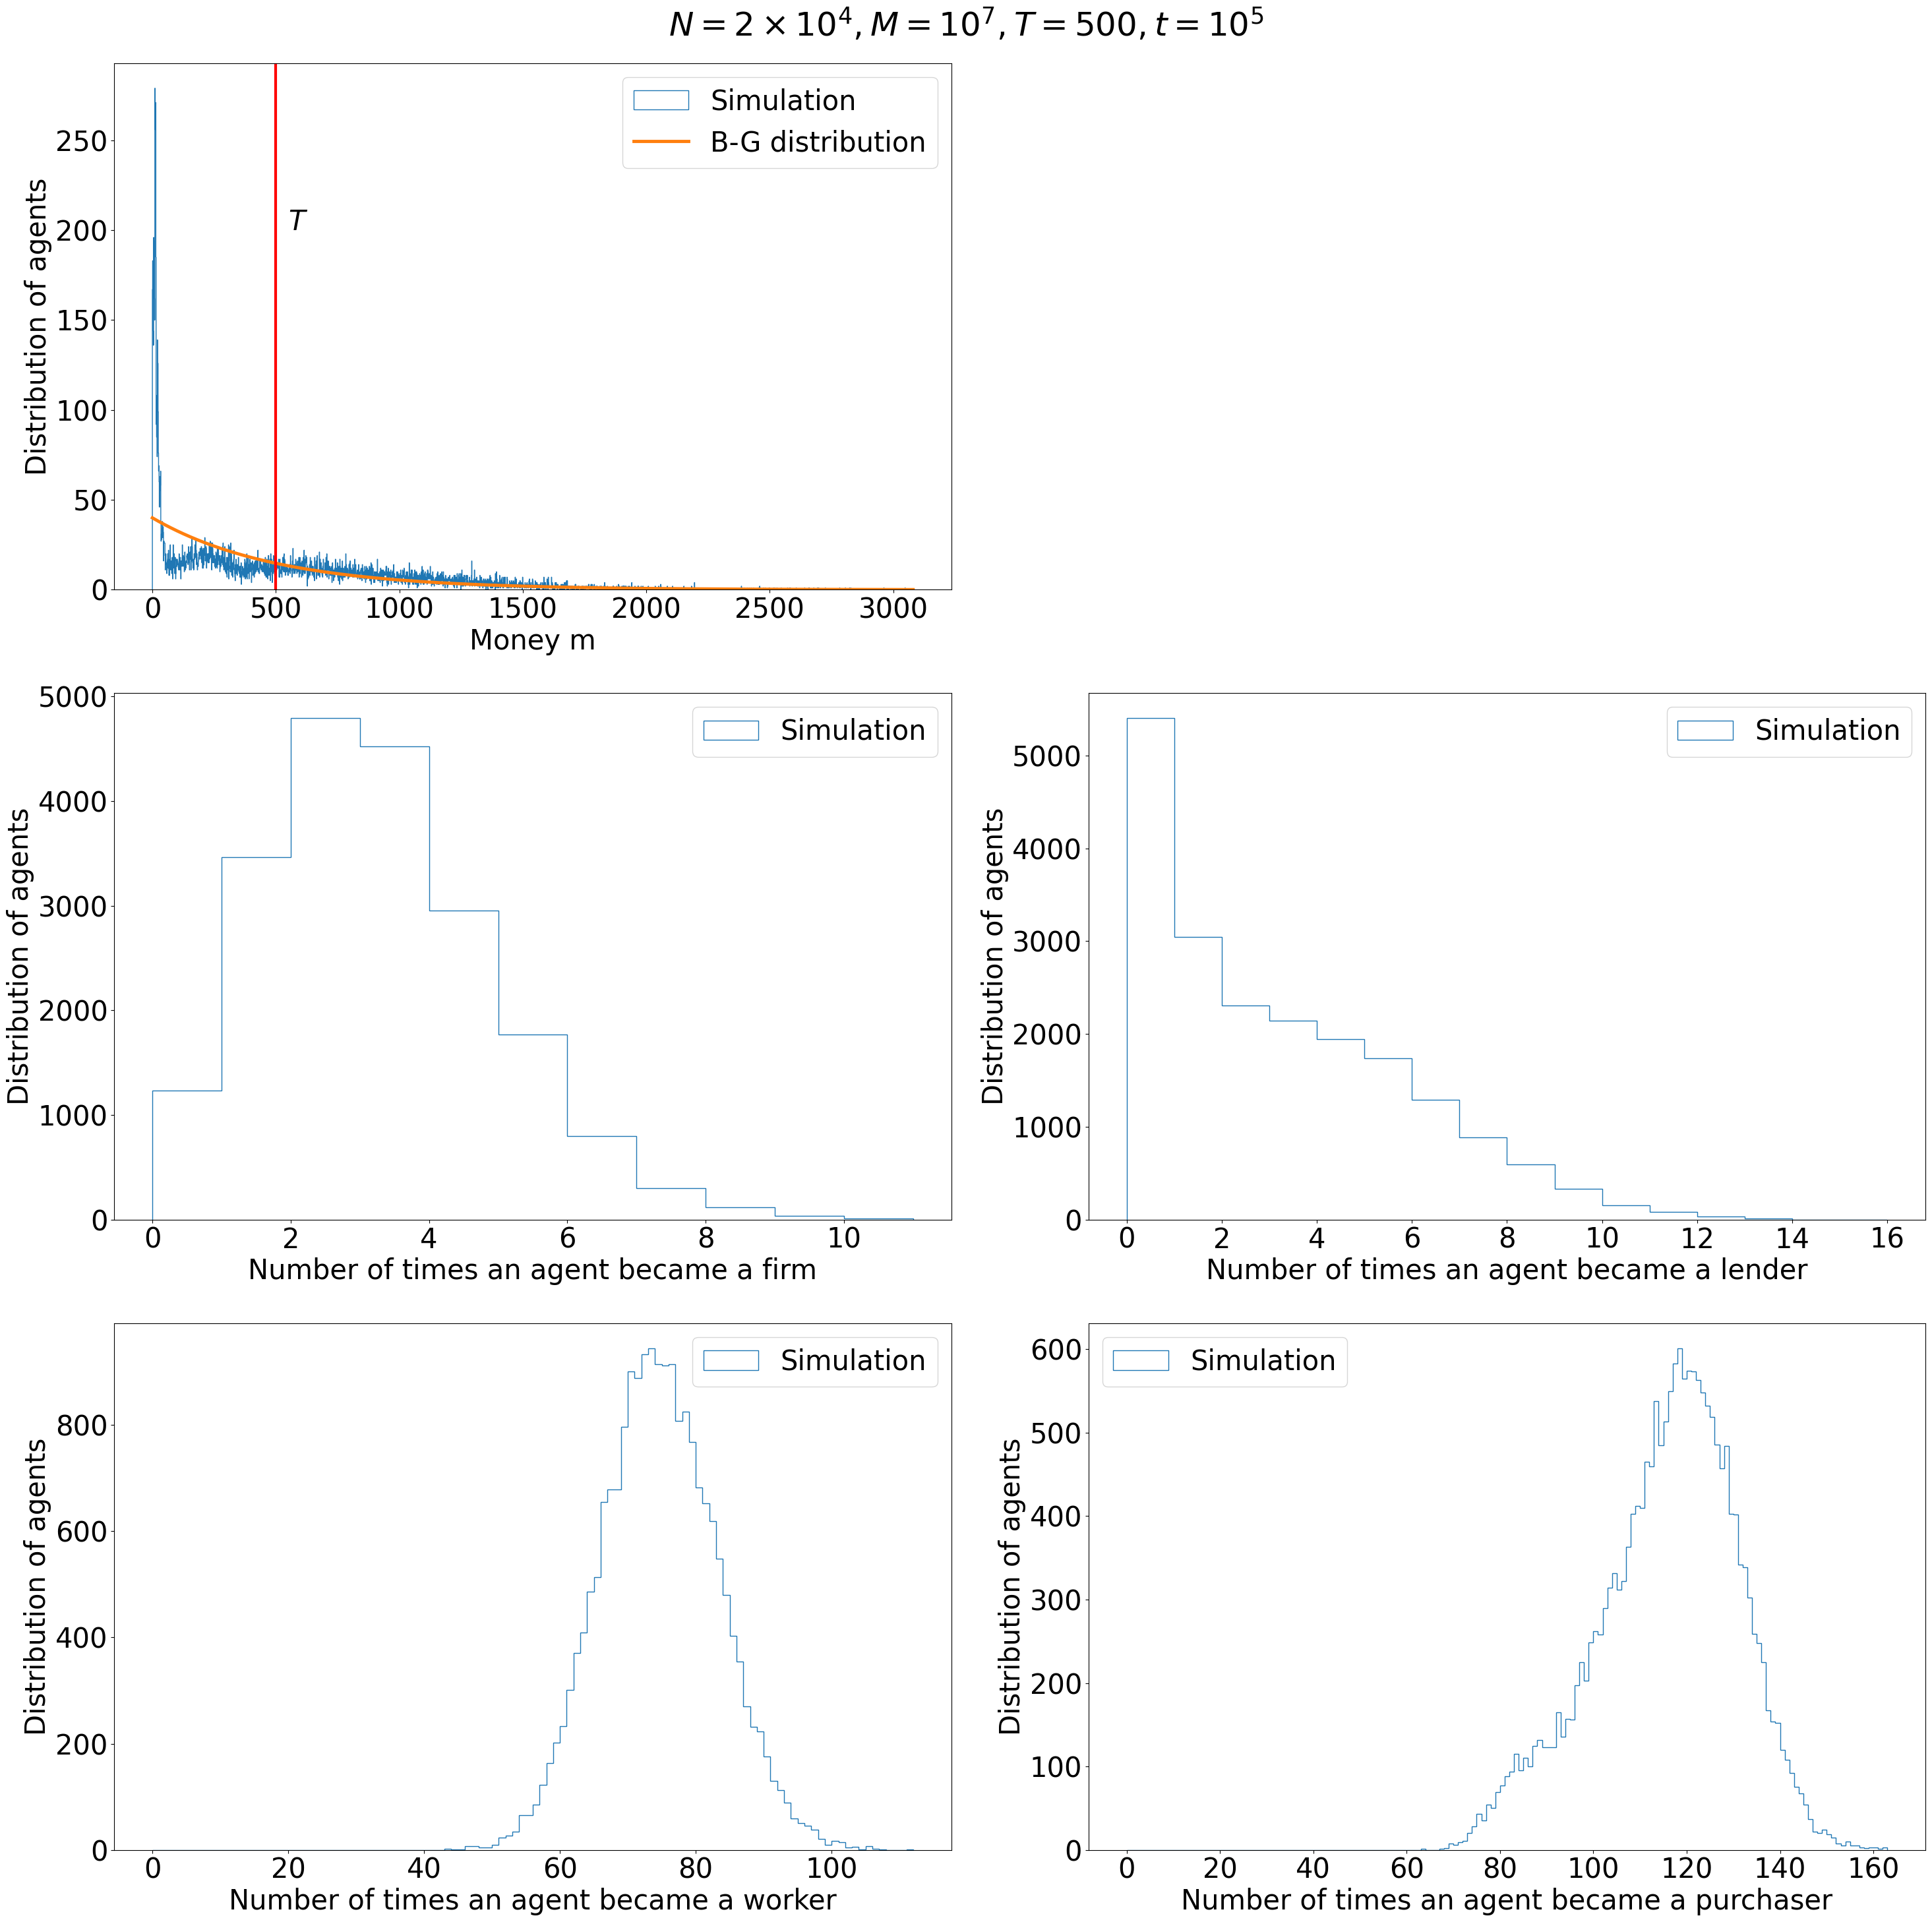

In [33]:
plt.rcParams.update({'font.size': 30})

fig,ax = plt.subplots(3,2,figsize=(30,30))

fig.suptitle(r"$N = 2 \times 10^{4}, M = 10^{7}, T = 500, t = 10^{5}$")

ax[0,0].hist(final_m_array, bins=range(nb_m_bins+1), label="Simulation", histtype='step', density=False)
ax[0,0].plot(m_values, P_values, label="B-G distribution", linewidth=3.5)
ax[0,0].set_xlabel("Money m")
ax[0,0].set_ylabel("Distribution of agents")
#ax[0,0].axvline(x = T, color = 'r', label = 'Money temperature', linewidth=3.0)
ax[0,0].axvline(x = T, color = 'r', linewidth=3.0)
ax[0,0].legend()
#ax[0,0].set_ylim(0,60)
ax[0,0].text(T+50,200,r"$T$")

fig.delaxes(ax[0,1])

ax[1,0].hist(final_e_array, bins=range(nb_e_bins+1), label="Simulation", histtype='step', density=False)
ax[1,0].set_xlabel("Number of times an agent became a firm")
ax[1,0].set_ylabel("Distribution of agents")
ax[1,0].legend()

ax[1,1].hist(final_p_array, bins=range(nb_p_bins+1), label="Simulation", histtype='step', density=False)
ax[1,1].set_xlabel("Number of times an agent became a lender")
ax[1,1].set_ylabel("Distribution of agents")
ax[1,1].legend()

ax[2,0].hist(final_w_array, bins=range(nb_w_bins+1), label="Simulation", histtype='step', density=False)
ax[2,0].set_xlabel("Number of times an agent became a worker")
ax[2,0].set_ylabel("Distribution of agents")
ax[2,0].legend()

ax[2,1].hist(final_pu_array, bins=range(nb_pu_bins+1), label="Simulation", histtype='step', density=False)
ax[2,1].set_xlabel("Number of times an agent became a purchaser")
ax[2,1].set_ylabel("Distribution of agents")
ax[2,1].legend()

plt.tight_layout()
#path = f"Realistic_extra_texp={texp}.png"
#plt.savefig(path)
plt.show()